In [1]:
import pandas as pd
import numpy as np

### 1.层次化索引

使你能在一个轴上拥有多个索引级别。即让你能以低维度形式处理高维度数据。

In [2]:
data = pd.Series(np.random.randn(9), index=[['a', 'a', 'a', 'b', 'b', 'c', 'c', 'd', 'd'],
                                           [1,2,3,1,3,1,2,2,3]])

In [3]:
data

a  1   -0.061830
   2    0.432442
   3    1.631619
b  1   -1.880731
   3   -0.245873
c  1   -0.534143
   2   -2.388760
d  2   -0.005443
   3    2.153834
dtype: float64

In [4]:
data.index

MultiIndex(levels=[['a', 'b', 'c', 'd'], [1, 2, 3]],
           labels=[[0, 0, 0, 1, 1, 2, 2, 3, 3], [0, 1, 2, 0, 2, 0, 1, 1, 2]])

对于一个层次化索引的对象，使用所谓的部分索引，选取数据子集的操作更简单

In [5]:
data['b']

1   -1.880731
3   -0.245873
dtype: float64

In [6]:
data['b':'c']

b  1   -1.880731
   3   -0.245873
c  1   -0.534143
   2   -2.388760
dtype: float64

In [8]:
data.loc[['b', 'd']]  # 传入列表，选取特定行

b  1   -1.880731
   3   -0.245873
d  2   -0.005443
   3    2.153834
dtype: float64

In [13]:
# 在内层中进行选取
data.loc[:, 2]  # 在所有第一列标签中选取，然后第二列标签为2的行

a    0.432442
c   -2.388760
d   -0.005443
dtype: float64

层次化索引在数据重塑和基于分组的操作（如透视表生成）中很重要。

In [14]:
# 通过unstack()方法将这段数据重新安排到一个DataFrame中
data.unstack()

,1,2,3
a,-0.061830,0.432442,1.631619
b,-1.880731,NaN,-0.245873
c,-0.534143,-2.388760,NaN
d,NaN,-0.005443,2.153834


In [15]:
# unstack的逆运算是stack
data.unstack().stack()

a  1   -0.061830
   2    0.432442
   3    1.631619
b  1   -1.880731
   3   -0.245873
c  1   -0.534143
   2   -2.388760
d  2   -0.005443
   3    2.153834
dtype: float64

对于一个DataFrame，每条轴都可以有分层索引

In [26]:
frame = pd.DataFrame(np.arange(12).reshape((4,3)), index=[['a', 'a', 'b', 'b'], [1, 2, 1, 2]],
                    columns=[['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']])

In [17]:
frame

Ohio     Colorado
    Green Red    Green
a 1     0   1        2
  2     3   4        5
b 1     6   7        8
  2     9  10       11

各层都可以有名字（字符串、python对象）。指定名称

In [30]:
frame.index.names = ['key1', 'key2']
frame.columns.names = ['state', 'color']

In [20]:
frame  # 注意区分索引名state、color与行标签

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

In [21]:
frame['Ohio']

color      Green  Red
key1 key2            
a    1         0    1
     2         3    4
b    1         6    7
     2         9   10

可以单独创建MultiIndex然后复用。

In [28]:
pd.MultiIndex.from_arrays([['Ohio', 'Ohio', 'Colorado'], ['Green', 'Red', 'Green']], names=['state', 'color'])

MultiIndex(levels=[['Colorado', 'Ohio'], ['Green', 'Red']],
           labels=[[1, 1, 0], [0, 1, 0]],
           names=['state', 'color'])

#### 重排与分级排序

有时，你需要重新调整某条轴上各级别的顺序，或根据指定级别上的值对数据进行排序。swaplevel接受两个级别编号或名称，并饭回一个互相交换了级别的新对象（数据不变）

In [31]:
frame.swaplevel('key1', 'key2')

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
2    a        3   4        5
1    b        6   7        8
2    b        9  10       11

In [34]:
frame

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
     2        3   4        5
b    1        6   7        8
     2        9  10       11

sort_index根据单个级别中的值对数据进行排序。交换级别时，常常用到sort_index，最终结果就是按照指定顺序进行字母排序

In [38]:
frame.sort_index(level=1)  # 这里level有0 和1

state      Ohio     Colorado
color     Green Red    Green
key1 key2                   
a    1        0   1        2
b    1        6   7        8
a    2        3   4        5
b    2        9  10       11

In [39]:
frame.swaplevel(0, 1).sort_index(level=0)

state      Ohio     Colorado
color     Green Red    Green
key2 key1                   
1    a        0   1        2
     b        6   7        8
2    a        3   4        5
     b        9  10       11

#### 根据级别汇总统计

许多对DataFrame和Series的描述和汇总统计都有一个level选项，它用于指定在某条轴单行求和的级别。

In [41]:
frame.sum(level='key2')  

state  Ohio     Colorado
color Green Red    Green
key2                    
1         6   8       10
2        12  14       16

In [42]:
frame.sum(level='color', axis=1)

color      Green  Red
key1 key2            
a    1         2    1
     2         8    4
b    1        14    7
     2        20   10

实际利用了pandas的groupby功能，稍后介绍

#### 使用DataFrame的列进行索引

想要将DataFrame的一个或多个列当做行索引来用，或希望将行索引变成DataFrame的列

In [44]:
frame = pd.DataFrame({'a': range(7), 'b': range(7, 0, -1), 'c': ['one', 'one', 'one', 'two', 'two', 'two', 'two'], 'd': [0, 1, 2, 0, 1, 2, 3]})

In [45]:
frame

,a,b,c,d
0,0,7,one,0
1,1,6,one,1
2,2,5,one,2
3,3,4,two,0
4,4,3,two,1
5,5,2,two,2
6,6,1,two,3


DataFrame的set_index函数将一个或多个列转换为行索引，并创建一个新的DataFrame

In [54]:
frame2 = frame.set_index(['c', 'd'])  # 决定级别索引顺序

In [55]:
frame2

a  b
c   d      
one 0  0  7
    1  1  6
    2  2  5
two 0  3  4
    1  4  3
    2  5  2
    3  6  1

默认情况下，成为索引的列会移除，使用drop参数保留

In [56]:
frame.set_index(['c', 'd'], drop=False)

a  b    c  d
c   d              
one 0  0  7  one  0
    1  1  6  one  1
    2  2  5  one  2
two 0  3  4  two  0
    1  4  3  two  1
    2  5  2  two  2
    3  6  1  two  3

reset_index的功能和set_index相反，层次化索引的级别会被转移到列里面

In [57]:
frame2.reset_index()

,c,d,a,b
0,one,0,0,7
1,one,1,1,6
2,one,2,2,5
3,two,0,3,4
4,two,1,4,3
5,two,2,5,2
6,two,3,6,1


### 2.合并数据集

1. pandas.merge可根据一个或多个键将不同的DataFrame中的行连接起来。类似数据库join操作
2. pandas.concat可以沿着一条轴将多个对象堆叠到一起
3. 实例方法combine_first可以将重复数据拼接在一起，用一个对象中的值填充另一个对象中缺失的值

#### 数据库风格的DataFrame合并

数据集的合并（merge）或连接（join）通过键将行连接

In [3]:
df1 = pd.DataFrame({'key': list('bbacaab'), 'data1': np.arange(7)})

In [5]:
df2 = pd.DataFrame({'key': list('abd'), 'data2': range(3)})

In [6]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,a,5
6,b,6


In [7]:
df2

,key,data2
0,a,0
1,b,1
2,d,2


In [16]:
pd.merge(df1, df2)  # 只存在两个df共有的数据,即自然连接

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


In [10]:
# 指明根据哪一个列进行连接
pd.merge(df1, df2, on='key')

,key,data1,data2
0,b,0,1
1,b,1,1
2,b,6,1
3,a,2,0
4,a,4,0
5,a,5,0


如果两个对象的列名不同，可以分别进行指定

In [13]:
df3 = pd.DataFrame({'lkey': list('bbacaab'), 'data1': range(7)})
df4 = pd.DataFrame({'rkey': list('abd'), 'data2': range(3)})

In [17]:
pd.merge(df3, df4, left_on='lkey', right_on='rkey')
# 类似等值连接

,lkey,data1,rkey,data2
0,b,0,b,1
1,b,1,b,1
2,b,6,b,1
3,a,2,a,0
4,a,4,a,0
5,a,5,a,0


默认情况下，merge做的是“内连接”，结果中的键是交集其他还有“left”、“right”、“outer”，“外连接”取的是键的并集，组合了左、右连接

In [18]:
pd.merge(df1, df2, how='outer')

,key,data1,data2
0,b,0.0,1.0
1,b,1.0,1.0
2,b,6.0,1.0
3,a,2.0,0.0
4,a,4.0,0.0
5,a,5.0,0.0
6,c,3.0,NaN
7,d,NaN,2.0


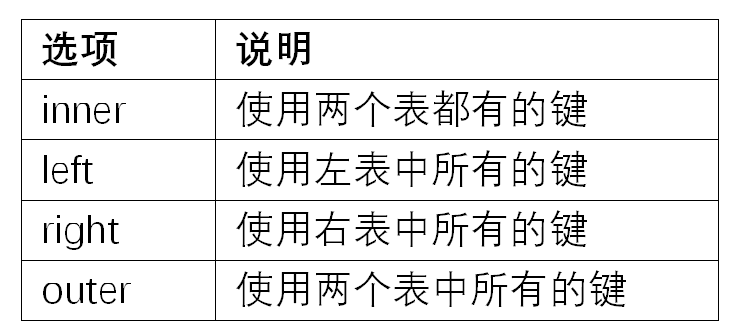

多对多连接产生的是行的笛卡尔积

In [19]:
df1 = pd.DataFrame({'key': list('bbacab'), 'data1': range(6)})
df2 = pd.DataFrame({'key': list('ababd'), 'data2': range(5)})

In [20]:
df1

,key,data1
0,b,0
1,b,1
2,a,2
3,c,3
4,a,4
5,b,5


In [21]:
df2

,key,data2
0,a,0
1,b,1
2,a,2
3,b,3
4,d,4


In [23]:
pd.merge(df1, df2, on='key', how='left')  # 根据左边的键表进行连接

,key,data1,data2
0,b,0,1.0
1,b,0,3.0
2,b,1,1.0
3,b,1,3.0
4,a,2,0.0
5,a,2,2.0
6,c,3,NaN
7,a,4,0.0
8,a,4,2.0
9,b,5,1.0


In [25]:
pd.merge(df1, df2, how='inner')  # 内连接，显示两者共有的键

,key,data1,data2
0,b,0,1
1,b,0,3
2,b,1,1
3,b,1,3
4,b,5,1
5,b,5,3
6,a,2,0
7,a,2,2
8,a,4,0
9,a,4,2


要根据多个键进行合并，传入一个由列名组成的列表即可

In [34]:
left = pd.DataFrame({'key1': ['foo', 'foo', 'bar'],
                    'key2': ['one', 'two', 'one'], 
                    'lval': list('123')})

In [39]:
right = pd.DataFrame({'key1': ['foo', 'foo', 'bar', 'bar'],
                     'key2': ['one', 'one', 'one', 'two'],
                     'rval': list('4567')})

In [40]:
left

,key1,key2,lval
0,foo,one,1
1,foo,two,2
2,bar,one,3


In [41]:
right

,key1,key2,rval
0,foo,one,4
1,foo,one,5
2,bar,one,6
3,bar,two,7


In [43]:
pd.merge(left, right, on=['key1', 'key2'], how='outer')  # 外连接

,key1,key2,lval,rval
0,foo,one,1,4
1,foo,one,1,5
2,foo,two,2,NaN
3,bar,one,3,6
4,bar,two,NaN,7


在进行列列连接时，DataFrame对象中的索引会被丢弃

合并时需考虑对重复列名的处理。suffixes选项指定附加到左右两个df对象的重叠列名上的字符串

In [44]:
pd.merge(left, right, on='key1')

,key1,key2_x,lval,key2_y,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


In [45]:
pd.merge(left, right, on='key1', suffixes=('_left', '_right'))

,key1,key2_left,lval,key2_right,rval
0,foo,one,1,one,4
1,foo,one,1,one,5
2,foo,two,2,one,4
3,foo,two,2,one,5
4,bar,one,3,one,6
5,bar,one,3,two,7


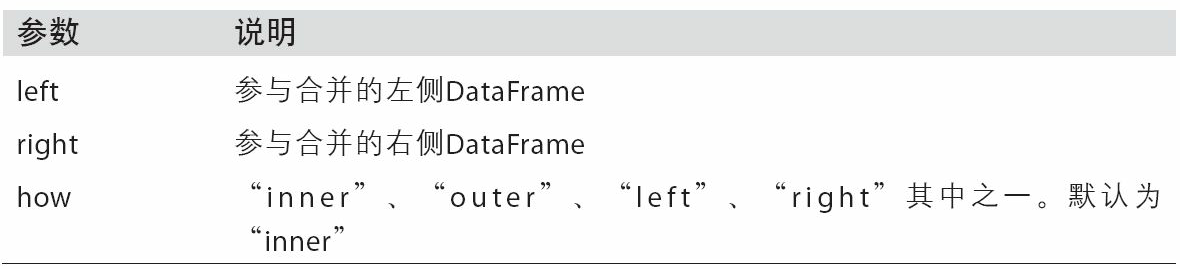

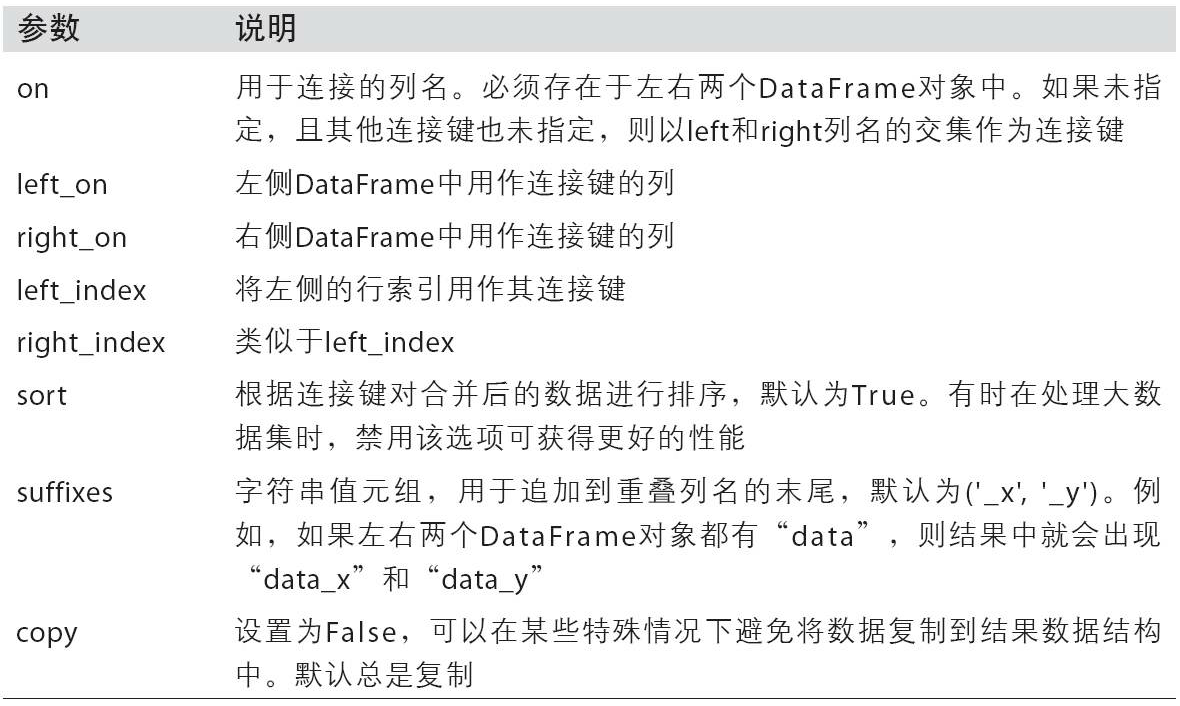

indicator添加特殊的列_merge，它可以指明每个行的来源，它的值有left_only right_only both，根据每行合并数据的来源

#### 索引上的合并

有时候，DataFrame中的连接键位于索引中。传入left_index=True或right_index=True以说明索引应该被用作连接键

In [46]:
left1 = pd.DataFrame({'key': list('abaabc'),
                     'value': range(6)})
right1 = pd.DataFrame({'group_val': [3.5, 7]}, index=list('ab'))

In [47]:
left1

,key,value
0,a,0
1,b,1
2,a,2
3,a,3
4,b,4
5,c,5


In [48]:
right1

,group_val
a,3.5
b,7.0


In [51]:
pd.merge(left1, right1, left_on='key', right_index=True, how='outer')  
# 根据左边的键进行连接，右边的索引也作为键,外连接取并集

,key,value,group_val
0,a,0,3.5
2,a,2,3.5
3,a,3,3.5
1,b,1,7.0
4,b,4,7.0
5,c,5,NaN


对于层次化索引，比较复杂。索引合并默认是多键合并

In [53]:
lefth = pd.DataFrame({'key1': ['Ohio', 'Ohio', 'Ohio', 'Nevada', 'Nevada'],
                     'key2': [2000, 2001, 2002, 2001, 2002], 
                     'data': np.arange(5.)})

In [55]:
righth = pd.DataFrame(np.arange(12).reshape((6, 2)),
                     index=[['Nevada', 'Nevada', 'Ohio', 'Ohio', 'Ohio', 'Ohio'],
                           [2001, 2000, 2000, 2000, 2001, 2002]], 
                     columns=['event1', 'event2'])

In [56]:
lefth

,key1,key2,data
0,Ohio,2000,0.0
1,Ohio,2001,1.0
2,Ohio,2002,2.0
3,Nevada,2001,3.0
4,Nevada,2002,4.0


In [58]:
righth

event1  event2
Nevada 2001       0       1
       2000       2       3
Ohio   2000       4       5
       2000       6       7
       2001       8       9
       2002      10      11

In [62]:
# 必须以列表的形式指明用作合并键的多个列（用how='outer'对重复索引值得处理）
pd.merge(lefth, righth, left_on=['key1', 'key2'], right_index=True, how='outer')

,key1,key2,data,event1,event2
0,Ohio,2000,0.0,4.0,5.0
0,Ohio,2000,0.0,6.0,7.0
1,Ohio,2001,1.0,8.0,9.0
2,Ohio,2002,2.0,10.0,11.0
3,Nevada,2001,3.0,0.0,1.0
4,Nevada,2002,4.0,NaN,NaN
4,Nevada,2000,NaN,2.0,3.0


同时合并双方的索引也没问题

In [63]:
left2 = pd.DataFrame([[1., 2.], [3., 4.], [5., 6.]],index=list('ace'), columns=['Ohio', 'Nevada'])

In [64]:
right2 = pd.DataFrame([[7., 8.], [9., 10.], [11., 12.], [13, 14]], index=list('bcde'), columns=['Missouri', 'Alabama'])

In [65]:
left2

,Ohio,Nevada
a,1.0,2.0
c,3.0,4.0
e,5.0,6.0


In [68]:
right2

,Missouri,Alabama
b,7.0,8.0
c,9.0,10.0
d,11.0,12.0
e,13.0,14.0


In [69]:
# 根据左右索引进行连接
pd.merge(left2, right2, how='outer', left_index=True, right_index=True)

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


DataFrame还有一个便捷的join实例方法，方便快速地实现按索引合并。还可用于合并多个带有相同或相似索引的DataFrame对象，但要求没有重叠的列

In [70]:
left2.join(right2, how='outer')

,Ohio,Nevada,Missouri,Alabama
a,1.0,2.0,NaN,NaN
b,NaN,NaN,7.0,8.0
c,3.0,4.0,9.0,10.0
d,NaN,NaN,11.0,12.0
e,5.0,6.0,13.0,14.0


对于简单的索引合并，你可以向join传入一组df，如df3.join([df1, df2])

#### 轴向连接

另一种合并运算也被称作连接（concatenation）、绑定（binding）、堆叠（stacking）

In [71]:
arr = np.arange(12).reshape((3, 4))
arr

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [73]:
np.concatenate([arr, arr], axis=1)  # 在列上连接数组

array([[ 0,  1,  2,  3,  0,  1,  2,  3],
       [ 4,  5,  6,  7,  4,  5,  6,  7],
       [ 8,  9, 10, 11,  8,  9, 10, 11]])

对于pandas对象，带有标签的轴使你能够进一步推广数组的连接运算。

In [75]:
s1 = pd.Series([0, 1], index=list('ab'))
s2 = pd.Series([2, 3, 4], index=list('cde'))
s3 = pd.Series([5, 6], index=list('fg'))

In [76]:
print(s1, s2, s3)

a    0
b    1
dtype: int64 c    2
d    3
e    4
dtype: int64 f    5
g    6
dtype: int64


In [78]:
pd.concat([s1, s2, s3])  # 使用concat将值和索引粘合在一起

a    0
b    1
c    2
d    3
e    4
f    5
g    6
dtype: int64

In [81]:
# 在列上进行连接
pd.concat([s1, s2, s3], axis=1, sort=False)

,0,1,2
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


In [82]:
s4 = pd.concat([s1, s3])

In [83]:
s4

a    0
b    1
f    5
g    6
dtype: int64

In [84]:
pd.concat([s1, s4], axis=1, join='inner')  # 得到连接后的交集

,0,1
a,0,0
b,1,1


In [85]:
# 通过join_axes指定要在其他轴上使用的索引
pd.concat([s1, s4], axis=1, join_axes=[['a', 'c', 'b', 'e']])

,0,1
a,0.0,0.0
c,NaN,NaN
b,1.0,1.0
e,NaN,NaN


参与连接的片段在结果中区分不开，可以使用keys参数在连接轴上创建一个层次化索引

In [90]:
result = pd.concat([s1, s2, s3], keys=['one', 'two', 'three'])
result

one    a    0
       b    1
two    c    2
       d    3
       e    4
three  f    5
       g    6
dtype: int64

In [91]:
result.unstack()  # 解除索引堆叠

,a,b,c,d,e,f,g
one,0.0,1.0,NaN,NaN,NaN,NaN,NaN
two,NaN,NaN,2.0,3.0,4.0,NaN,NaN
three,NaN,NaN,NaN,NaN,NaN,5.0,6.0


In [93]:
# 沿着axis=1对Series进行合并，则keys就会成为DataFrame的列头
pd.concat([s1, s2, s3], axis=1, keys=['one', 'two', 'three'], sort=False)

,one,two,three
a,0.0,NaN,NaN
b,1.0,NaN,NaN
c,NaN,2.0,NaN
d,NaN,3.0,NaN
e,NaN,4.0,NaN
f,NaN,NaN,5.0
g,NaN,NaN,6.0


同样的逻辑也使用与DataFrame对象

In [94]:
df1 = pd.DataFrame(np.arange(6).reshape((3, 2)), index=list('abc'), columns=['one', 'two'])

In [95]:
df2 = pd.DataFrame(5 + np.arange(4).reshape(2, 2), index=list('ac'), columns=['three', 'four'])

In [96]:
df1

,one,two
a,0,1
b,2,3
c,4,5


In [97]:
df2

,three,four
a,5,6
c,7,8


In [100]:
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'], sort=False)

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

如果传入的不是列表而是一个字典，则字典的键就会被当做keys选项的值

In [103]:
pd.concat({'level1': df1, 'level2': df2}, axis=1, sort=False)  # 效果同上

level1     level2     
     one two  three four
a      0   1    5.0  6.0
b      2   3    NaN  NaN
c      4   5    7.0  8.0

In [105]:
# 使用names参数命名创建的轴级别
pd.concat([df1, df2], axis=1, keys=['level1', 'level2'], names=['upper', 'lower'], sort=False)

upper level1     level2     
lower    one two  three four
a          0   1    5.0  6.0
b          2   3    NaN  NaN
c          4   5    7.0  8.0

DataFrame的行索引不包含任何相关数据

In [107]:
df1 = pd.DataFrame(np.random.randn(3, 4), columns=list('abcd'))
df2 = pd.DataFrame(np.random.randn(2, 3), columns=list('bda'))

In [108]:
df1

,a,b,c,d
0,-0.334400,0.615725,-1.141074,0.212537
1,1.957738,-0.970203,-0.157265,-0.577709
2,-0.806551,1.627328,0.125486,-2.344491


In [109]:
df2

,b,d,a
0,0.698068,-1.183393,0.330104
1,-0.116802,0.349641,2.517096


In [117]:
pd.concat([df1, df2],sort=False, ignore_index=True)
# 增加ignore_index参数使df的行索引无效化，即不保留原索引

,a,b,c,d
0,-0.334400,0.615725,-1.141074,0.212537
1,1.957738,-0.970203,-0.157265,-0.577709
2,-0.806551,1.627328,0.125486,-2.344491
3,0.330104,0.698068,NaN,-1.183393
4,2.517096,-0.116802,NaN,0.349641


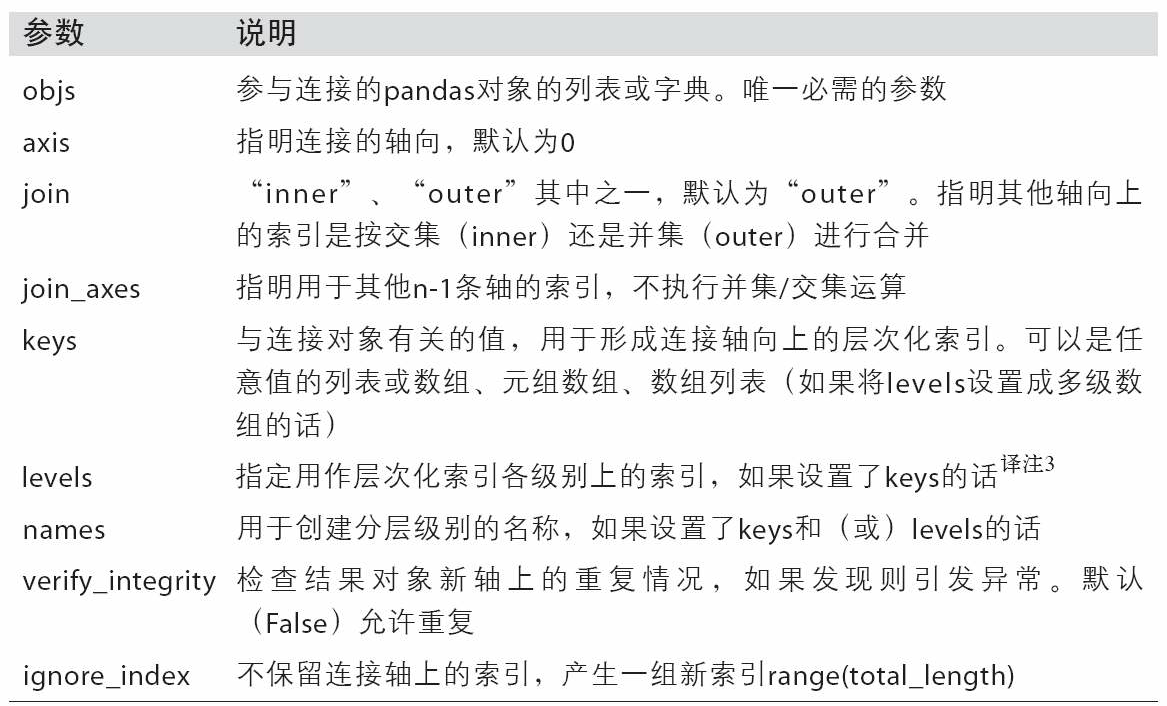

#### 合并重叠数据

还有一种数据组合问题不能用简单的合并（merge）或连接（concatenation）运算来处理。比如，你可能有索引部分或全部重叠的两个数据集。

In [118]:
a = pd.Series([np.nan, 2.5, np.nan, 3.5, 4.5, np.nan], index=list('fedcba'))

In [119]:
b = pd.Series(np.arange(len(a), dtype=np.float64), index=list('fedcba'))

In [120]:
b[-1] = np.nan

In [121]:
a

f    NaN
e    2.5
d    NaN
c    3.5
b    4.5
a    NaN
dtype: float64

In [122]:
b

f    0.0
e    1.0
d    2.0
c    3.0
b    4.0
a    NaN
dtype: float64

In [124]:
np.where(pd.isnull(a), b, a)  
# a中未空则为True，该值从b中选，其余的值从a中选

array([0. , 2.5, 2. , 3.5, 4.5, nan])

Series还有一个combine_first方法，实现一样的功能，还带有pandas的数据对齐功能

In [130]:
b[:-2].combine_first(a[2:])  
# 用a[2:]的数据给b[:-2]的缺失数据打补丁，即根据对应索引填充缺失数据

a    NaN
b    4.5
c    3.0
d    2.0
e    1.0
f    0.0
dtype: float64

In [136]:
df1 = pd.DataFrame({'a': [1, np.nan, 5, np.nan],
                   'b': [np.nan, 2, np.nan, 6],
                   'c': range(2, 18, 4)})

In [138]:
df2 = pd.DataFrame({'a': [5, 4, np.nan, 3, 7],
                   'b': [np.nan, 3, 4, 6, 8]})

In [139]:
df1

,a,b,c
0,1.0,NaN,2
1,NaN,2.0,6
2,5.0,NaN,10
3,NaN,6.0,14


In [140]:
df2

,a,b
0,5.0,NaN
1,4.0,3.0
2,NaN,4.0
3,3.0,6.0
4,7.0,8.0


In [141]:
df1.combine_first(df2)

,a,b,c
0,1.0,NaN,2.0
1,4.0,2.0,6.0
2,5.0,4.0,10.0
3,3.0,6.0,14.0
4,7.0,8.0,NaN


### 3.重塑和轴轴向旋转

有许多用于重新排列表格型数据的基础运算。这些函数也称作重塑（reshape）或轴向旋转（pivot）运算。

#### 重塑层次化索引

层次化索引为DataFrame数据的重排提供了一种良好一致性的方式。功能有二：
- stack：将数据的列‘旋转’为行
- unstack：将数据的行‘旋转’为列

In [17]:
data = pd.DataFrame(np.arange(6).reshape(2, 3), index=pd.Index(['Ohio', 'Colorado'],name='state'), 
                    columns=pd.Index(['one', 'two', 'three'],name='numbers'))

In [18]:
data

numbers,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


In [19]:
# 对该数据使用stack方法即可以将列转换为行,得到一个series
result = data.stack()  # 即实现层次化索引
result

state     numbers
Ohio      one        0
          two        1
          three      2
Colorado  one        3
          two        4
          three      5
dtype: int32

In [149]:
# 使用unstack将其重排为一个DF，即将层次化索引展开
result.unstack()

numbers,one,two,three
state,,,
Ohio,0,1,2
Colorado,3,4,5


默认情况下，unstack和stack操作的是最内层，可传入分层编号

In [152]:
result.unstack(0)

state,Ohio,Colorado
numbers,,
one,0,3
two,1,4
three,2,5


In [153]:
# 或者
result.unstack('state')

state,Ohio,Colorado
numbers,,
one,0,3
two,1,4
three,2,5


如果不是所有的级别值都能在个分组中找到的话，则unstack操作可能会引入缺失数据

In [2]:
s1 = pd.Series([0, 1, 2, 3], index=list('abcd'))
s2 = pd.Series([4, 5, 6], index=list('cde'))
data2 = pd.concat([s1, s2], keys=['one', 'two'])

In [3]:
s1

a    0
b    1
c    2
d    3
dtype: int64

In [4]:
s2

c    4
d    5
e    6
dtype: int64

In [5]:
data2

one  a    0
     b    1
     c    2
     d    3
two  c    4
     d    5
     e    6
dtype: int64

In [7]:
data2.unstack()  # 找不到的级别值引入缺失值

,a,b,c,d,e
one,0.0,1.0,2.0,3.0,NaN
two,NaN,NaN,4.0,5.0,6.0


stack默认会滤除缺失数据，因此该运算是可逆的

In [8]:
data2.unstack().stack()

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
two  c    4.0
     d    5.0
     e    6.0
dtype: float64

In [10]:
data2.unstack().stack(dropna=False)  # 逆运算时保留缺失值

one  a    0.0
     b    1.0
     c    2.0
     d    3.0
     e    NaN
two  a    NaN
     b    NaN
     c    4.0
     d    5.0
     e    6.0
dtype: float64

在对DataFrame进行unstack操作时，作为旋转轴的级别将会成为结果中的最低级别

In [20]:
df = pd.DataFrame({'left': result, 'right': result + 5}, columns=pd.Index(['left', 'right'], name='side'))

In [21]:
df

side              left  right
state    numbers             
Ohio     one         0      5
         two         1      6
         three       2      7
Colorado one         3      8
         two         4      9
         three       5     10

In [22]:
df.unstack('state')

side    left          right         
state   Ohio Colorado  Ohio Colorado
numbers                             
one        0        3     5        8
two        1        4     6        9
three      2        5     7       10

当调用stack时，我们可以指明轴的名字

In [23]:
df.unstack('state').stack('side')

state          Colorado  Ohio
numbers side                 
one     left          3     0
        right         8     5
two     left          4     1
        right         9     6
three   left          5     2
        right        10     7

#### 将‘长格式’旋转为‘宽格式’

多个时间序列数据通常是一所谓的‘长格式’（long）或‘堆叠格式’（stacked）存储在数据库和CSV中。

In [35]:
data = pd.read_csv('E:\jupyter notebook\pydata-book-2nd-edition\examples\macrodata.csv')

In [36]:
data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [37]:
periods = pd.PeriodIndex(year=data.year, quarter=data.quarter, name='date')

In [38]:
columns = pd.Index(['realgdp', 'infl', 'unemp'], name='item')

In [39]:
data = data.reindex(columns=columns)

In [41]:
data.index = periods.to_timestamp('D', 'end')

In [42]:
ldata = data.stack().reset_index().rename(columns={0: 'value'})

这就是多个时间序列（或者其他带有两个或多个键的可观察数据，我们的键是date和item）的长格式。表中的每行代表一次观察。

关系型数据库中的数据经常是这样存储的，因为固定架构（即列名和数据类型）有一个好处：随着表中数据的添加，item列中的值得种类能够增加。在前面的例子中，date和item就是主键，不仅提供了关系完整性，而且提供了更为简单的查询支持。

有时候，使用这样的数据会很麻烦，你可能更喜欢DataFrame，不同的item值分别形成一列，date列中的时间戳则用作索引。DataFrame的pivot方法可以实现这个转换。

In [43]:
pivoted = ldata.pivot('date', 'item', 'value')
pivoted

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2
1960-06-30,0.14,2834.390,5.2
1960-09-30,2.70,2839.022,5.6
1960-12-31,1.21,2802.616,6.3
1961-03-31,-0.40,2819.264,6.8


前两个传递的值分别用作行和列索引，最后一个可选值则是用于填充DataFrame的数据列。假设有两个需要同时重塑的数据列

In [48]:
ldata['value2'] = np.random.randn(len(ldata))

In [49]:
ldata[:10]

,date,item,value,value2
0,1959-03-31,realgdp,2710.349,1.493455
1,1959-03-31,infl,0.000,0.278919
2,1959-03-31,unemp,5.800,-0.562321
3,1959-06-30,realgdp,2778.801,-0.603671
4,1959-06-30,infl,2.340,-0.704098
5,1959-06-30,unemp,5.100,0.181897
6,1959-09-30,realgdp,2775.488,-1.154506
7,1959-09-30,infl,2.740,-0.292572
8,1959-09-30,unemp,5.300,-2.041740
9,1959-12-31,realgdp,2785.204,1.830573


In [ ]:
如果忽略最后一个参数，得到的DataFrame就会带有层次化的列

In [50]:
pivoted = ldata.pivot('date', 'item')

In [51]:
pivoted[:5]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  0.278919  1.493455 -0.562321
1959-06-30  2.34  2778.801   5.1 -0.704098 -0.603671  0.181897
1959-09-30  2.74  2775.488   5.3 -0.292572 -1.154506 -2.041740
1959-12-31  0.27  2785.204   5.6 -0.315874  1.830573  0.136502
1960-03-31  2.31  2847.699   5.2  0.078798  0.014889 -0.998728

In [52]:
pivoted['value'][:5]

item,infl,realgdp,unemp
date,,,
1959-03-31,0.00,2710.349,5.8
1959-06-30,2.34,2778.801,5.1
1959-09-30,2.74,2775.488,5.3
1959-12-31,0.27,2785.204,5.6
1960-03-31,2.31,2847.699,5.2


pivot其实就是用set_index创建层次化索引，再用unstack重塑

In [53]:
unstacked = ldata.set_index(['date', 'item']).unstack('item')

In [54]:
unstacked[:7]

value                    value2                    
item        infl   realgdp unemp      infl   realgdp     unemp
date                                                          
1959-03-31  0.00  2710.349   5.8  0.278919  1.493455 -0.562321
1959-06-30  2.34  2778.801   5.1 -0.704098 -0.603671  0.181897
1959-09-30  2.74  2775.488   5.3 -0.292572 -1.154506 -2.041740
1959-12-31  0.27  2785.204   5.6 -0.315874  1.830573  0.136502
1960-03-31  2.31  2847.699   5.2  0.078798  0.014889 -0.998728
1960-06-30  0.14  2834.390   5.2  0.804997  0.361045 -1.727773
1960-09-30  2.70  2839.022   5.6 -0.248352 -0.321305  0.570737

#### 将‘宽格式’旋转为‘长格式’

旋转DataFrame的逆运算是pandas.melt。它不是讲一列转换到多个新的DataFrame，而是合并多个列为一个，产生一个比输入长的DataFrame

In [55]:
df = pd.DataFrame({'key': ['foo', 'bar', 'baz'], 'A': [1, 2, 3], 'B': [4, 5, 6],
                  'C': [7, 8, 9]})

In [56]:
df

,key,A,B,C
0,foo,1,4,7
1,bar,2,5,8
2,baz,3,6,9


key列可能是分组指标，其他列是数据值。当使用pandas.melt，我们必须指明那些列是分组指标

In [57]:
melted = pd.melt(df, ['key'])

In [58]:
melted

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6
6,foo,C,7
7,bar,C,8
8,baz,C,9


使用pivot，可以重塑会原来的样子

In [59]:
reshaped = melted.pivot('key', 'variable', 'value')

In [60]:
reshaped

variable,A,B,C
key,,,
bar,2,5,8
baz,3,6,9
foo,1,4,7


因为pivot的结果从列创建了一个索引，用作行标签，我们可以使用reset_index将数据移回列

In [64]:
reshaped.reset_index()

variable,key,A,B,C
0,bar,2,5,8
1,baz,3,6,9
2,foo,1,4,7


你还可以指定列的子集，作为值得列：

In [65]:
pd.melt(df, id_vars=['key'], value_vars=['A', 'B'])

,key,variable,value
0,foo,A,1
1,bar,A,2
2,baz,A,3
3,foo,B,4
4,bar,B,5
5,baz,B,6


pandas.melt也可以不用分组指标：

In [67]:
pd.melt(df, value_vars=['A', 'B', 'C'])

,variable,value
0,A,1
1,A,2
2,A,3
3,B,4
4,B,5
5,B,6
6,C,7
7,C,8
8,C,9


In [68]:
pd.melt(df, value_vars=['key', 'A', 'B'])

,variable,value
0,key,foo
1,key,bar
2,key,baz
3,A,1
4,A,2
5,A,3
6,B,4
7,B,5
8,B,6
